In [1]:
import rospy
from sensor_msgs.msg import Image
from geometry_msgs.msg import Twist

In [2]:
rospy.init_node('watcher')
def snap():
    return rospy.wait_for_message('/camera/rgb/image_raw', Image, timeout=1.)
cmd_vel_pub = rospy.Publisher('cmd_vel', Twist, queue_size=1)

In [391]:
import cv2, numpy as np
from cv_bridge import CvBridge
from matplotlib import pyplot as plt

(480, 640, 3)


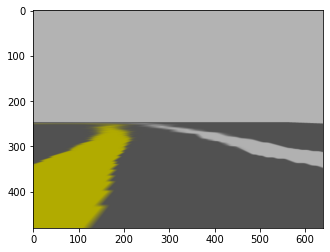

In [698]:
bridge = CvBridge()
def image():
    msg = snap()
    return bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
def show(img, **kwargs):
    plt.imshow(img[...,::-1], **kwargs)

img = image()
print(img.shape)
show(img)

Hue:


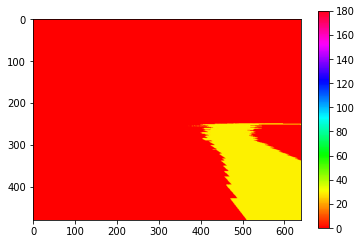

Saturation:


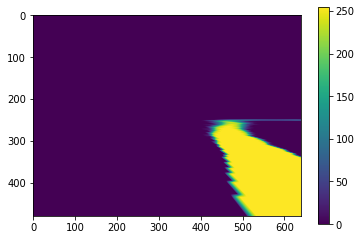

Value:


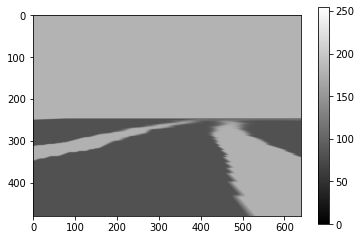

In [393]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = np.moveaxis(hsv, -1, 0)

print("Hue:")
show(hue,vmin=0,vmax=180,cmap='hsv')
plt.colorbar()
plt.show()

print("Saturation:")
show(sat,vmin=0,vmax=255)
plt.colorbar()
plt.show()

print("Value:")
show(val,vmin=0,vmax=255,cmap='gray')
plt.colorbar()
plt.show()

In [7]:
import scipy.stats
def pval(dist, points):
    "Returns the p-value of points on a symmetric distribution."
    cumul = dist.cdf(points)
    return 2*np.minimum(cumul, 1-cumul)

def pval_lower(dist, points):
    "Returns the lower p-value of points on a distribution."
    return dist.cdf(points)

def pval_upper(dist, points):
    "Returns the upper p-value of points on a distribution."
    return dist.sf(points)

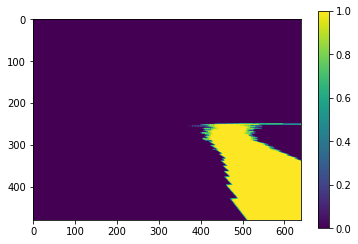

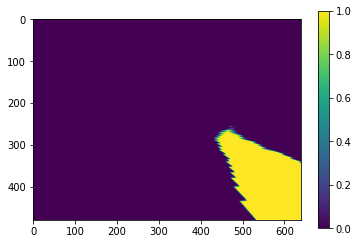

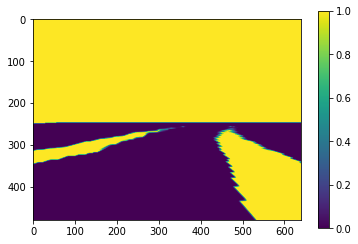

In [394]:
hue_dist_yellow = scipy.stats.norm(29, 5)
sat_dist_yellow = scipy.stats.expon(0, 5)
val_dist_yellow = scipy.stats.expon(78, 5)
inv_tf = lambda x: 255 - x

pval_hue = pval(hue_dist_yellow, hue.astype(float))
show(pval_hue, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_sat = pval_upper(sat_dist_yellow, inv_tf(sat).astype(float))
show(pval_sat, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_val = pval_upper(val_dist_yellow, inv_tf(val).astype(float))
show(pval_val, vmin=0, vmax=1)
plt.colorbar()
plt.show()

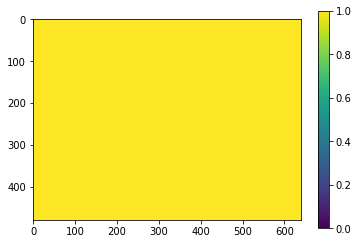

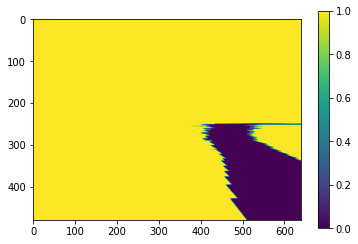

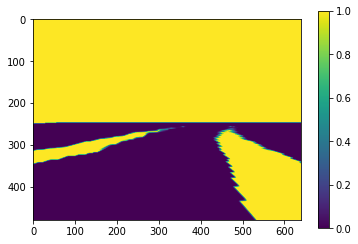

In [395]:
hue_dist_white = scipy.stats.norm(0, np.inf)
sat_dist_white = scipy.stats.expon(0, 5)
val_dist_white = scipy.stats.expon(78, 5)
inv_tf = lambda x: 255 - x

pval_hue = pval(hue_dist_white, hue.astype(float))
show(pval_hue, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_sat = pval_upper(sat_dist_white, sat.astype(float))
show(pval_sat, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_val = pval_upper(val_dist_white, inv_tf(val).astype(float))
show(pval_val, vmin=0, vmax=1)
plt.colorbar()
plt.show()

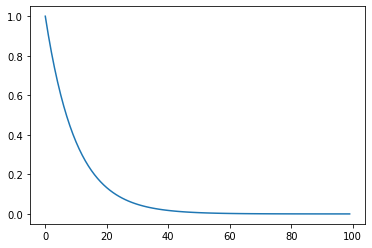

In [9]:
plt.plot(scipy.stats.expon(0,1).pdf(np.linspace(0,10,100)))

(array([35509.,  1038.,   836.,   854.,   808.,  1010.,  1120.,  1228.,
         1520.,  3094.]),
 array([ 78. ,  87.6,  97.2, 106.8, 116.4, 126. , 135.6, 145.2, 154.8,
        164.4, 174. ]),
 <BarContainer object of 10 artists>)

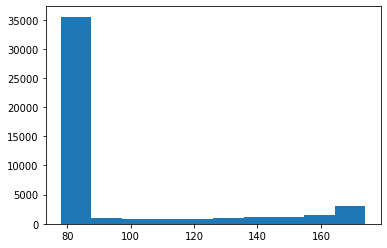

In [10]:
plt.hist(255-val[hue>10],bins=10)

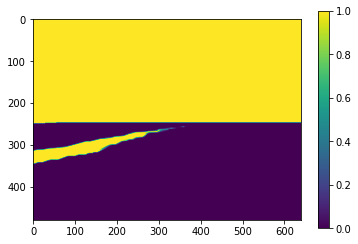

In [396]:
pval_tot = pval_hue * pval_sat *pval_val
show(pval_tot, vmin=0, vmax=1)
plt.colorbar()

In [397]:
def filter(hsv):
    # Backwards compatibility
    return filter_yellow(hsv) 

def filter_yellow(hsv):
    hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
    pval_hue = pval(hue_dist_yellow, hue)
    pval_sat = pval_upper(sat_dist_yellow, inv_tf(sat))
    pval_val = pval_upper(val_dist_yellow, inv_tf(val))
    return pval_hue * pval_sat * pval_val

def filter_white(hsv):
    hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
    pval_hue = pval(hue_dist_white, hue)
    pval_sat = pval_upper(sat_dist_white, sat)
    pval_val = pval_upper(val_dist_white, inv_tf(val))
    return pval_hue * pval_sat * pval_val

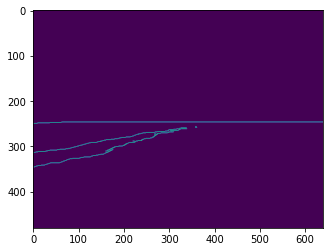

In [398]:
filter_img = (pval_tot * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 200, 240)
show(edges)

In [12]:
def angle_dist(a, b):
    "Calculates the acute distance between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, 2*np.pi - dist)

def angle_diff(a, b):
    "Calculates the acute difference between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, dist - 2*np.pi)

def recenter(angles, mid_angle):
    return np.mod(angles - mid_angle + np.pi, 2*np.pi) + mid_angle - np.pi
    
WIDTH = 640
HEIGHT = 480
def idx_to_xy(idx):
    return idx[...,::-1] * (1,-1) + (0, HEIGHT)
def xy_to_idx(xy):
    return ((xy - (0, HEIGHT)) * (1,-1))[...,::-1]

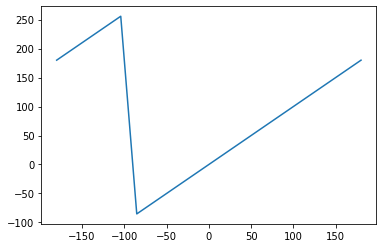

In [13]:
x = np.linspace(-180,180,20)
y = np.rad2deg(recenter(np.deg2rad(x), np.deg2rad(90)))
plt.plot(x,y)

In [27]:
edge_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
center = (edges.shape[1]/2,0)
diff_xy = idx_to_xy(edge_idx) - center
edge_rad = recenter(np.arctan2(diff_xy[:,1],diff_xy[:,0]), np.deg2rad(90))
edge_rad

array([2.16492756, 2.16186955, 2.15879893, ..., 3.13211426, 3.13206913,
       3.13685335])

[479 109] [345 639]


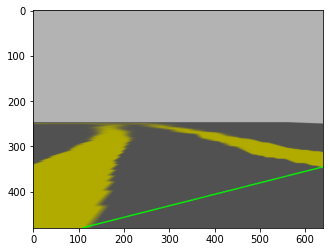

In [28]:
left, right = edge_idx[[np.argmax(edge_rad), np.argmin(edge_rad)]]
print(left, right)
img_w_line = img.copy()
cv2.line(img_w_line, left[::-1], right[::-1], (0,255,0),2)
show(img_w_line)

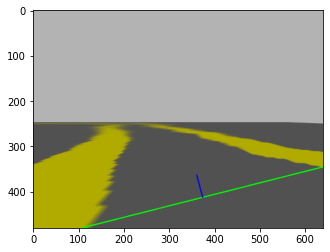

In [29]:
dist = 50

mid = np.mean([left, right],axis=0)
mid_xy = idx_to_xy(mid)
diff_xy = idx_to_xy(right) - idx_to_xy(left)
line_rad = np.arctan2(diff_xy[1], diff_xy[0])
theta = line_rad + np.deg2rad(90)
normal = np.array([np.cos(theta), np.sin(theta)])
next_pt = xy_to_idx(mid_xy + dist * normal)

cv2.line(img_w_line, mid[::-1].astype(int), next_pt[::-1].astype(int), (255,0,0),2)
show(img_w_line)

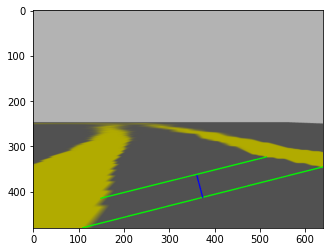

In [31]:
diff_xy = idx_to_xy(edge_idx) - idx_to_xy(next_pt)
edge_rad = np.arctan2(diff_xy[:,1],diff_xy[:,0])
edge_dist = np.linalg.norm(diff_xy,axis=-1)

filter_left = angle_dist(edge_rad, theta + np.deg2rad(90)) < np.deg2rad(1)
left = edge_idx[filter_left][np.argmin(edge_dist[filter_left])]

filter_right = angle_dist(edge_rad, theta - np.deg2rad(90)) < np.deg2rad(1)
right = edge_idx[filter_right][np.argmin(edge_dist[filter_right])]

cv2.line(img_w_line, left[::-1], right[::-1], (0,255,0),2)
show(img_w_line)

/tmp/ipykernel_3432/1058207534.py:3: RuntimeWarning: invalid value encountered in remainder
  dist = (a - b) % (2*np.pi)


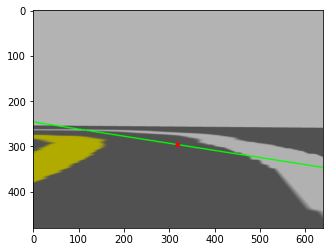

In [669]:
def search_by_angle(diff, angle):
    angles = np.arctan2(diff[:,1],diff[:,0])
    return np.argmin(angle_dist(angles, angle))

def cart_to_rad(coords):
    dist = np.linalg.norm(coords, axis=-1)
    angles = np.arctan2(coords[...,1],coords[...,0])
    return np.stack([dist, angles], axis=-1)

Y_VANISHING_NEAR = 105
Y_VANISHING_FAR = 220
CENTER = WIDTH / 2

def dist_tf(dist, y):
    coeff = ((y - Y_VANISHING_FAR) / (Y_VANISHING_NEAR - Y_VANISHING_FAR))
    return np.where(y < Y_VANISHING_FAR, np.inf, dist * coeff)

def perspective_tf(xy):
    x, y = xy[...,0], xy[...,1]
    coeff = (y + Y_VANISHING_NEAR) / (Y_VANISHING_FAR + Y_VANISHING_NEAR)
    x_tf = np.where(y > Y_VANISHING_FAR, np.nan, CENTER + (x - CENTER) * coeff)
    y_tf = np.where(y > Y_VANISHING_FAR, np.inf, y * coeff**2 * (HEIGHT / Y_VANISHING_FAR))
    return np.stack([x_tf, y_tf], axis=-1)

def mark_road(img, edges, dist=50, max_iter=10, angle_lim=45, angle_tol=5):
    # Transform points from perspective to top-down
    edge_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
    edge_xy = perspective_tf(idx_to_xy(edge_idx))

    #im = np.zeros((HEIGHT,WIDTH))
    #im[tuple(xy_to_idx(edge_xy).astype(int).T)] = 1
    #show(edges)
    #plt.show()
    #show(im)
    #plt.show()
    
    # Find start closest to bottom of screen (angle-wise)
    center = (CENTER,0)
    diff_xy = idx_to_xy(edge_idx) - center
    edge_rad = recenter(np.arctan2(diff_xy[:,1],diff_xy[:,0]), np.deg2rad(90))
    left_idx, right_idx = np.argmax(edge_rad), np.argmin(edge_rad)
    left_xy, right_xy = edge_xy[[left_idx, right_idx]]
    left, right = edge_idx[[left_idx, right_idx]]

    try:
        prev_mid = None
        for _ in range(max_iter):
            # Calculate normal angle
            diff_xy = right_xy - left_xy
            line_rad = np.arctan2(diff_xy[1], diff_xy[0])
            theta = line_rad + np.deg2rad(90)

            # Draw "rail" with midpoint
            mid = np.mean([left, right],axis=0)
            mid_xy = np.mean([left_xy, right_xy],axis=0)
            cv2.line(img, left[::-1], right[::-1], (0,255,0),2)
            cv2.circle(img, mid[::-1].astype(int), 5, (0,0,255), -1)

            # Draw midpoint connection
            if prev_mid is not None:
                cv2.line(img, prev_mid[::-1].astype(int), mid[::-1].astype(int), (0,0,255),2)

            # Continue to next point
            normal = np.array([np.cos(theta), np.sin(theta)])
            next_pt_xy = mid_xy + dist * normal
            #next_pt = mid + dist_tf(dist, mid[0]) * xy_to_idx(normal)
            #cv2.line(img, mid[::-1].astype(int), next_pt[::-1].astype(int), (255,0,0),2)

            # Find new edge points to left and right crossing next_pt
            diff_xy = edge_xy - next_pt_xy
            radial = cart_to_rad(diff_xy)
            left_filter = angle_dist(radial[:,1], theta + np.deg2rad(90)) < np.deg2rad(angle_lim)
            right_idx = np.argmin(angle_dist(radial[:,1], radial[left_filter,1,None] - np.deg2rad(180)), axis=-1)
            opposite_filter = angle_dist(radial[left_filter,1], radial[right_idx,1] - np.deg2rad(180)) < np.deg2rad(angle_tol)

            #print(radial[np.stack([np.indices(edge_idx.shape)[0,:,0][left_filter][opposite_filter],right_idx[opposite_filter]],axis=-1)] * (1,180/np.pi))

            # Choose next line based on minimum distance
            distances = radial[left_filter,0][opposite_filter] + radial[right_idx,0][opposite_filter]
            line_idx = np.argmin(distances)
            left_xy = edge_xy[left_filter][opposite_filter][line_idx]
            right_xy = edge_xy[right_idx][opposite_filter][line_idx]
            left = edge_idx[left_filter][opposite_filter][line_idx]
            right = edge_idx[right_idx][opposite_filter][line_idx]

            #min_lengths = np.min(np.linalg.norm(rights - lefts[:,None,:],axis=-1), axis=1, where=opposite_filter, initial=1000)
            #left_idx = np.argmin(min_lengths)
            #left = lefts[left_idx]
            #right_idx = np.argmin(rights[left_idx, opposite_filter[left_idx]])
            #right = rights[left_idx, right_idx]
            #print(radial[left_idx], radial[right_idx])

            # Save last midpoint
            prev_mid = mid
    except ValueError as e:
        pass

img_w_line = img.copy()
mark_road(img_w_line, edges, dist=10, max_iter=10)
show(img_w_line)

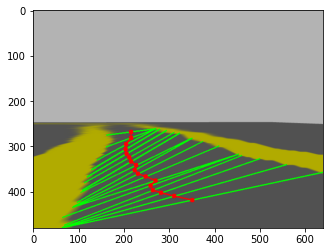

In [179]:
img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_img = (filter(hsv) * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 20, 240)

mark_road(img, edges, dist=15, max_iter=50)
show(img)

In [247]:
def cross_arc(point, normal, radius):
    x0, y0 = np.moveaxis(point, -1, 0)
    xN, yN = np.moveaxis(normal, -1, 0)

    # Quadratic formula
    a = xN**2 + yN**2
    b = 2*(x0*xN + y0*yN)
    c = x0**2 + y0**2 - radius**2

    # Solve
    discriminant = b**2 - 4*a*c
    valid = discriminant >= 0
    sqrt_disc = np.where(valid, np.sqrt(discriminant,where=valid), np.nan)
    pos = (-b + sqrt_disc) / (2*a)
    neg = (-b - sqrt_disc) / (2*a)
    t = np.stack([pos, neg], axis=-1)

    # Return points
    return point[...,None,:] + t[...,None] * normal[...,None,:]

In [248]:
pt = np.array([[1,1],[1,2]])
nrm = np.array([1,-1])
pts = cross_arc(pt, nrm, 3)
print(pts.shape)
pts

(2, 2, 2)


array([[[ 2.87082869, -0.87082869],
        [-0.87082869,  2.87082869]],

       [[ 3.        ,  0.        ],
        [ 0.        ,  3.        ]]])

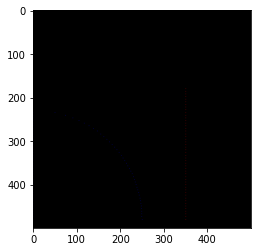

In [402]:
img = np.zeros([500,500,3],dtype=np.uint8)

radius = 250
start = np.array([350,0])
direction = np.array([0,1])
normal = direction[...,::-1]
t = np.linspace(0,300,50)

pts_line = start[...,None,:] + t[...,None] * direction[...,None,:]
pts_arc = cross_arc(pts_line, normal, radius)

line_idx = xy_to_idx(pts_line).astype(int).reshape(-1,2).clip(0,500)
arc_idx = xy_to_idx(pts_arc).astype(int).reshape(-1,2).clip(0,500)

img[tuple(line_idx.T)] = (0,0,255)
img[tuple(arc_idx.T)] = (255,0,0)

show(img)

In [403]:
dist_drive = 200
start_angle = 0
angle_drive = dist_drive / radius
angle = np.arctan2(pts_arc[...,1], pts_arc[...,0])
filter_arc = (angle >= start_angle) & (angle < start_angle + angle_drive)

diff = pts_arc - pts_line[...,None,:]
print(diff.shape)
dist = np.sum(diff**2,axis=-1)
print(dist.shape)
R2 = np.min(dist, axis=-1, where=filter_arc, initial=np.inf)
print(R2)
R2_tot = np.mean(R2, axis=-1, where=~np.isinf(R2))
R2_tot

(50, 2, 2)
(50, 2)
[10000.         10015.00162341 10060.10105672 10135.58284313
 10241.92408577 10379.7988082  10550.08418954 10753.86881046
 10992.46309444 11267.41218441 11580.51156038 11933.82578342
 12329.71084811 12770.84074629 13260.23899675 13801.31608783
 14397.91402765 15054.35951874 15775.527696   16566.91892899
 17434.75194482 18386.07755707 19428.91870798 20572.44452489
 21827.18893415 23205.32850189 24721.04028119 26390.96969743
 28234.85286939 30276.36070412            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf]


15744.844487104732

In [404]:
#search_x = np.linspace(-640, 320, 20)
#search_y = np.linspace(-480, 480, 20)

#search_space = np.meshgrid(search_x, search_y)
#centerpoints = np.stack([*centerpoints], axis=-1).reshape(-1,2)

middle = (320,0)
search_x = np.linspace(-640, 640*2, 100)
search_x = search_x[np.abs(search_x - middle[0]) > 2 * dist_drive / np.pi]
print(search_x)
centerpoints = np.stack([search_x,np.zeros_like(search_x)],axis=-1)
centerpoints.shape

[-640.         -620.60606061 -601.21212121 -581.81818182 -562.42424242
 -543.03030303 -523.63636364 -504.24242424 -484.84848485 -465.45454545
 -446.06060606 -426.66666667 -407.27272727 -387.87878788 -368.48484848
 -349.09090909 -329.6969697  -310.3030303  -290.90909091 -271.51515152
 -252.12121212 -232.72727273 -213.33333333 -193.93939394 -174.54545455
 -155.15151515 -135.75757576 -116.36363636  -96.96969697  -77.57575758
  -58.18181818  -38.78787879  -19.39393939    0.           19.39393939
   38.78787879   58.18181818   77.57575758   96.96969697  116.36363636
  135.75757576  155.15151515  174.54545455  465.45454545  484.84848485
  504.24242424  523.63636364  543.03030303  562.42424242  581.81818182
  601.21212121  620.60606061  640.          659.39393939  678.78787879
  698.18181818  717.57575758  736.96969697  756.36363636  775.75757576
  795.15151515  814.54545455  833.93939394  853.33333333  872.72727273
  892.12121212  911.51515152  930.90909091  950.3030303   969.6969697
  989.0

(86, 2)

In [405]:
start_offs = middle - centerpoints
radius = np.linalg.norm(start_offs, axis=-1)
print('radius:',radius.shape)
pts_line_offs = pts_line[None,...] - centerpoints[:,None,:]
print('pts_line_offs:',pts_line_offs.shape)

pts_arc = cross_arc(pts_line_offs, normal[None,...], radius[:,None])
print('pts_arc:',pts_arc.shape)

dist_drive = 200
#start_angle = np.arctan2(start_offs[...,1], start_offs[...,0])
#print('start_angle:',start_angle.shape)
angle_drive = dist_drive / radius
print('angle_drive:',angle_drive.shape)
angle = np.arctan2(pts_arc[...,1], pts_arc[...,0])
print('angle:',angle.shape)
angle = np.where(start_offs[...,None,None,0] > 0, angle, np.pi - angle)
filter_arc = (angle >= 0) & (angle < angle_drive[:,None,None])
#filter_arc = (angle >= start_angle[:,None,None]) & (angle < (start_angle + angle_drive)[:,None,None])
print('filter_arc:',filter_arc.shape)

diff = pts_arc - pts_line_offs[...,None,:]
print('diff:',diff.shape)
dist = np.sum(diff**2,axis=-1)
print('dist:',dist.shape)
R2 = np.min(dist, axis=-1, where=filter_arc, initial=np.inf)
print('R2:',R2.shape)
R2_tot = np.mean(R2, axis=-1, where=~np.isinf(R2))
print('R2_tot:',R2_tot.shape)
#R2_tot[np.isnan(R2_tot)] = np.inf
best_candidate_idx = np.argmin(R2_tot)
print('best R2_tot:',R2_tot[best_candidate_idx])

print(R2[best_candidate_idx])
print(angle_drive[0])

centerpoint = centerpoints[best_candidate_idx]
centerpoint

radius: (86,)
pts_line_offs: (86, 50, 2)
pts_arc: (86, 50, 2, 2)
angle_drive: (86,)
angle: (86, 50, 2)
filter_arc: (86, 50, 2)
diff: (86, 50, 2, 2)
dist: (86, 50, 2)
R2: (86, 50)
R2_tot: (86,)
best R2_tot: 415.0836741317561
[9.00000000e+02 8.97173584e+02 8.88719006e+02 8.74710363e+02
 8.55271445e+02 8.30576176e+02 8.00849242e+02 7.66366900e+02
 7.27457993e+02 6.84505153e+02 6.37946232e+02 5.88275948e+02
 5.36047785e+02 4.81876137e+02 4.26438744e+02 3.70479421e+02
 3.14811121e+02 2.60319357e+02 2.07966019e+02 1.58793629e+02
 1.13930080e+02 7.45939077e+01 4.21001737e+01 1.78670135e+01
 3.42294522e+00 4.15034680e-01 1.06180285e+01 3.59445905e+01
 7.84567979e+01 1.40379079e+02 2.24112814e+02 3.32252854e+02
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf]
0.2083333333

array([717.57575758,   0.        ])

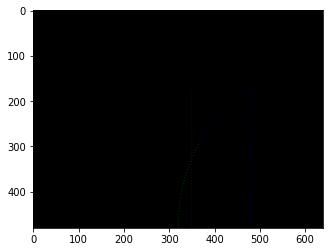

In [406]:
img = np.zeros([480,640,3],dtype=np.uint8)

pts_arc_chosen = pts_arc[best_candidate_idx] + centerpoints[best_candidate_idx]
line_idx = xy_to_idx(pts_line).astype(int).reshape(-1,2).clip(0,479)
arc_idx = xy_to_idx(pts_arc_chosen).astype(int).reshape(-1,2).clip(0,479)
arc_drive_idx = xy_to_idx(pts_arc_chosen[filter_arc[best_candidate_idx]]).astype(int).reshape(-1,2).clip(0,479)

img[tuple(line_idx.T)] = (0,0,255)
img[tuple(arc_idx.T)] = (255,0,0)
img[tuple(arc_drive_idx.T)] = (0,255,0)

show(img)

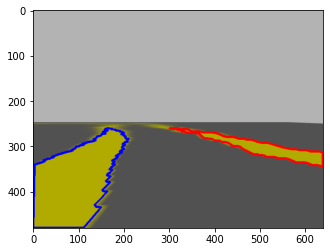

In [46]:
ret, thresh = cv2.threshold(filter_img, 200, 255, 0)
contours, hierarchy = cv2.findContours(filter_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
img_copy = img.copy()
cv2.drawContours(img_copy, contours, 0, (0,0,255), 3)
cv2.drawContours(img_copy, contours, 1, (255,0,0), 3)
show(img_copy)

In [51]:
cv2.pointPolygonTest(contours[0], (300,300), True)

-39.20459156782532

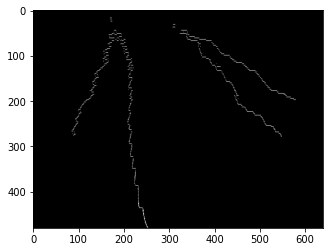

In [63]:
edge_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
edge_xy = perspective_tf(idx_to_xy(edge_idx))

# Draw top-down perspective
img_overhead = np.zeros_like(img)
img_overhead[tuple(xy_to_idx(edge_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (255, 255, 255)

show(img_overhead)

In [79]:
def to_cv(idx):
    return np.round(idx[...,::-1]).astype(int).clip(-9999, 9999)

near left: (140,)
near right: (184,)


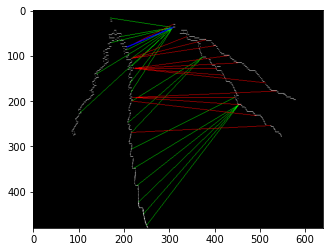

In [126]:
from scipy.spatial import KDTree
left_edges_xy = edge_xy[edge_xy[:,0] < 300][::5]
right_edges_xy = edge_xy[edge_xy[:,0] > 300][::5]
tree_left = KDTree(left_edges_xy)
tree_right = KDTree(right_edges_xy)

_, nearest_left = tree_left.query(right_edges_xy)
_, nearest_right = tree_right.query(left_edges_xy)

print("near left:", nearest_left.shape)
print("near right:", nearest_right.shape)

img_overhead_drawn = img_overhead.copy()

# Left to Right
for i in range(0, len(left_edges_xy), 10):
    left_xy = left_edges_xy[i]
    right_xy = right_edges_xy[nearest_right[i]]
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (0,255,0), 1)

# Right to Left
for i in range(0, len(right_edges_xy), 10):
    right_xy = right_edges_xy[i]
    left_xy = left_edges_xy[nearest_left[i]]
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (0,0,255), 1)

nearest_mutual_filter = nearest_right[nearest_left] == np.arange(nearest_left.shape[0])
nearest_mutual_left = nearest_left[nearest_mutual_filter]
nearest_mutual_right = nearest_right[nearest_left][nearest_mutual_filter]
nearest_mutual_xy = np.stack([left_edges_xy[nearest_mutual_left], right_edges_xy[nearest_mutual_right]], axis=-2)

# Mutual
for left_xy, right_xy in nearest_mutual_xy:
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (255,0,0), 2)

show(img_overhead_drawn)

nearest left: (70, 10)
nearest right: (92, 10)
nearest search: (70, 10, 10)
mutuals found: 12


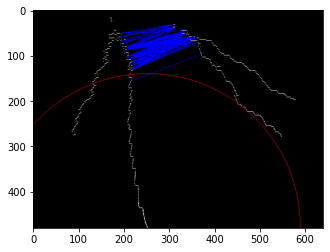

In [149]:
from scipy.spatial import KDTree
left_edges_xy = edge_xy[edge_xy[:,0] < 300][::10]
right_edges_xy = edge_xy[edge_xy[:,0] > 300][::10]
tree_left = KDTree(left_edges_xy)
tree_right = KDTree(right_edges_xy)

d_left, nearest_left = tree_left.query(right_edges_xy, k=10) # Dist of right points from left structure
d_right, nearest_right = tree_right.query(left_edges_xy, k=10) # Dist of left points from right structure

d_left_min = np.min(d_left, axis=-1)
d_right_min = np.min(d_right, axis=-1)

print("nearest left:", nearest_left.shape)
print("nearest right:", nearest_right.shape)

img_overhead_drawn = img_overhead.copy()

nearest_mutual_search = nearest_right[nearest_left] == np.arange(nearest_left.shape[0])[:,None,None]

print("nearest search:", nearest_mutual_search.shape)

nearest_mutual_filter = np.any(nearest_mutual_search, axis=(-2,-1))

print("mutuals found:", np.count_nonzero(nearest_mutual_filter))

nearest_mutual_left = nearest_left[np.any(nearest_mutual_search, axis=-1)]
nearest_mutual_right = nearest_right[nearest_left][nearest_mutual_search]
nearest_mutual_xy = np.stack([left_edges_xy[nearest_mutual_left], right_edges_xy[nearest_mutual_right]], axis=-2)

# Mutual
for left_xy, right_xy in nearest_mutual_xy:
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (255,0,0), 1)

lowest_idx = np.argmin(left_edges_xy[:,1])
cv2.circle(img_overhead_drawn, to_cv(xy_to_idx(left_edges_xy[lowest_idx])), int(d_right[lowest_idx,0]), (0,0,255), 1)

show(img_overhead_drawn)

near left: (140,)
near right: (184,)


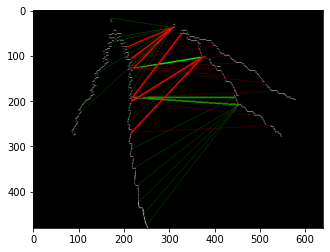

In [161]:
from scipy.spatial import KDTree
left_edges_xy = edge_xy[edge_xy[:,0] < 300][::5]
right_edges_xy = edge_xy[edge_xy[:,0] > 300][::5]
tree_left = KDTree(left_edges_xy)
tree_right = KDTree(right_edges_xy)

_, nearest_left = tree_left.query(right_edges_xy)
_, nearest_right = tree_right.query(left_edges_xy)

print("near left:", nearest_left.shape)
print("near right:", nearest_right.shape)

img_overhead_drawn = img_overhead.copy()

# Left to Right to Left
for i in range(0, len(left_edges_xy), 10):
    left_seed_xy = left_edges_xy[i]
    right_idx = nearest_right[i]
    right_xy = right_edges_xy[right_idx]
    left_idx = nearest_left[right_idx]
    left_xy = left_edges_xy[left_idx]
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_seed_xy)), to_cv(xy_to_idx(right_xy)), (0,100,0), 1)
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (0,255,0), 2)

# Right to Left to Right
for i in range(0, len(right_edges_xy), 10):
    right_seed_xy = right_edges_xy[i]
    left_idx = nearest_left[i]
    left_xy = left_edges_xy[left_idx]
    right_idx = nearest_right[left_idx]
    right_xy = right_edges_xy[right_idx]
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_seed_xy)), (0,0,100), 1)
    cv2.line(img_overhead_drawn, to_cv(xy_to_idx(left_xy)), to_cv(xy_to_idx(right_xy)), (0,0,255), 2)

show(img_overhead_drawn)

0.0052844307888721635

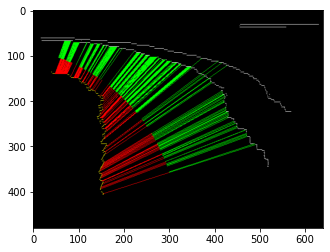

In [501]:
def L2_2(v):
    return np.inner(v,v)

def arc_record(center, r, pts, flip=False):
    v = pts - center
    disp = np.linalg.norm(v, axis=-1) - r
    x, y = np.moveaxis(v, -1, 0)
    if flip:
        x = -x
    theta = np.arctan2(y, x)
    return np.stack([theta, disp], axis=-1)

yc = 0
window_size = 20
window_threshold = 10
drive_threshold = 50
middle = CENTER
def residu(xc, debug=False):
    try:
        xc = xc[0]
    except:
        pass

    center = np.stack([xc, yc])
    r = np.linalg.norm((middle, 0) - center)
    turn_right = xc > middle
    
    left_records = arc_record(center, r, left_edges_xy, flip=turn_right)
    right_records = arc_record(center, r, right_edges_xy, flip=turn_right)

    # Enforce directionality
    left_records = left_records[(left_records[:,1] > 0) == turn_right]
    right_records = right_records[(right_records[:,1] < 0) == turn_right]

    records = np.concatenate([left_records, right_records])
    records = records[np.argsort(records[:,0], axis=0)] # Sort by theta

    if window_size > records.shape[0]:
        return np.inf
    
    windows = np.lib.stride_tricks.sliding_window_view(records, window_size, axis=0)
    windows = np.moveaxis(windows, -1, 1)

    discriminant = np.abs(np.sum(np.sign(windows[...,1]), axis=1))
    valid_windows = windows[discriminant < window_threshold]
    drive = valid_windows[...,0] * r
    good_windows = valid_windows[(np.max(drive, axis=1) - np.min(drive, axis=1) < drive_threshold)]

    left_disp = np.min(-good_windows[..., 1], axis=1, where=good_windows[..., 1] < 0, initial=np.inf)
    right_disp = np.min(good_windows[..., 1], axis=1, where=good_windows[..., 1] > 0, initial=np.inf)

    # TEST #
    if debug:
        img_overhead_drawn = img_overhead.copy()

        left = good_windows[good_windows[..., 1] == -left_disp[:, None]]
        right = good_windows[good_windows[..., 1] == right_disp[:, None]]

        vector_left = np.stack([np.cos(left[:,0]), np.sin(left[:,0])], axis=-1)
        if xc > CENTER:
            vector_left[:,0] *= -1
        arc_xy = center + vector_left * r
        left_xy = center + vector_left * (r - left_disp)[:,None]
        
        for a,b in zip(arc_xy, left_xy):
            cv2.line(img_overhead_drawn, to_cv(xy_to_idx(a)), to_cv(xy_to_idx(b)), (0,0,255), 1)

        vector_right = np.stack([np.cos(right[:,0]), np.sin(right[:,0])], axis=-1)
        if xc > CENTER:
            vector_right[:,0] *= -1
        arc_xy = center + vector_right * r
        right_xy = center + vector_right * (r + right_disp)[:,None]
        
        for a,b in zip(arc_xy, right_xy):
            cv2.line(img_overhead_drawn, to_cv(xy_to_idx(a)), to_cv(xy_to_idx(b)), (0,255,0), 1)

        show(img_overhead_drawn)
    # END TEST#


    residue = np.where(left_disp < right_disp, right_disp / left_disp, left_disp / right_disp)
    if residue.size == 0:
        return np.inf
    dist_drive = r * (good_windows[-1,-1,0] - good_windows[0,0,0])
    return np.mean(residue) / dist_drive

residu([-80], debug=True)

In [439]:
from scipy.optimize import differential_evolution
res = differential_evolution(residu, [(-9999, 9999), (0, WIDTH)])
res

     fun: 1.0055073571898174
     jac: array([ 0.00089084, -0.00264204])
 message: 'Optimization terminated successfully.'
    nfev: 1008
     nit: 27
 success: True
       x: array([529.68372936, 228.74815565])

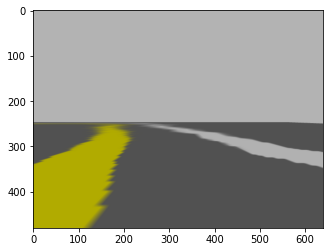

[[[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 ...

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]]


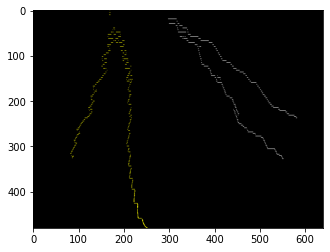

In [700]:
Y_VANISHING_NEAR = 105
Y_VANISHING_FAR = 225

img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_yellow_img = (filter_yellow(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white(hsv) * 255).astype(np.uint8)
filter_white_img[:260,:] = 0 # Erase sky
edges_yellow = cv2.Canny(filter_yellow_img, 20, 240)
edges_white = cv2.Canny(filter_white_img, 20, 240)

right_edges_idx = np.moveaxis(np.indices(edges_white.shape),0,-1)[edges_white>127].reshape(-1,2)
right_edges_xy = perspective_tf(idx_to_xy(right_edges_idx))

left_edges_idx = np.moveaxis(np.indices(edges_yellow.shape),0,-1)[edges_yellow>127].reshape(-1,2)
left_edges_xy = perspective_tf(idx_to_xy(left_edges_idx))

# Draw top-down perspective
img_overhead = np.zeros_like(img)
img_overhead[tuple(xy_to_idx(left_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (0, 255, 255)
img_overhead[tuple(xy_to_idx(right_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (255, 255, 255)

show(img)
plt.show()
show(img_overhead)

[-7677.4050229]


0.007794377096698509

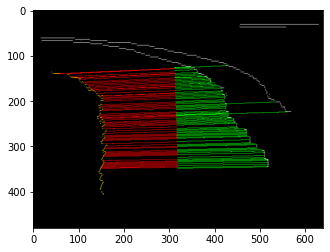

In [500]:
res = differential_evolution(residu, [(-9999, 9999)])
print(res.x)
residu(res.x, debug=True)

/tmp/ipykernel_3432/823629412.py:71: RuntimeWarning: divide by zero encountered in true_divide
  loss = np.where(left_min > right_min, left_min / right_min, right_min / left_min)
/tmp/ipykernel_3432/823629412.py:71: RuntimeWarning: invalid value encountered in true_divide
  loss = np.where(left_min > right_min, left_min / right_min, right_min / left_min)
/home/danealor/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/danealor/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan 1.48872332e+00
 1.03933376e+00 1.35697390e+00 6.60832185e-01 6.10274377e-01
 5.66028513e-01 5.36553465e-01 5.15037707e-01 4.61779194e-01
 5.90887800e-01 4.63588933e-01 4.41903476e-01 6.40103285e+01
 7.43608882e+00 9.78225828e-01 4.63966647e-01 4.26883065e-01
 3.99648307e-01 3.76587915e-01 3.62111589e-01 3.55975833e-01
 3.48952594e-01 3.44978854e-01 3.43588461e-01 3.41111522e-01
 3.46327891e-01 3.75069398e-01 3.90979240e-01 4.12408860e-01
 4.33805495e-01 4.59537846e-01 4.93296539e-01 5.29987684e-01
 5.63451242e-01 6.21781499e-01 7.45900491e-01 8.63975114e-01
 1.08250814e+00 1.87085221e+00 9.31907362e+01 1.37833855e+01
 2.37326509e+01 8.41618065e+01 1.09053203e+01 1.16843977e+02
 2.54767431e+01 2.22983898e+02 4.89555802e+01 1.39841683e+03
 1.54382028e+02 3.469904

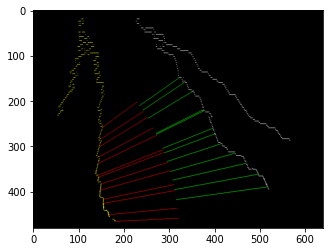

In [695]:
def arc_record(center, r, pts, flip):
    v = pts - center
    disp = np.linalg.norm(v, axis=-1) - r
    x, y = np.moveaxis(v, -1, 0)
    x = np.where(flip, -x, x)
    theta = np.arctan2(y, x)
    dist = theta * r
    return np.stack([dist, disp])

def fit_road(left_edges_xy, right_edges_xy, middle, num_test=100, bin_length=20, min_bin_pts=5, max_dist=500, draw_img=None):
    curvatures = np.linspace(-0.01, 0.01, num_test)
    centers = np.stack([middle + 1 / curvatures, np.zeros_like(curvatures)], axis=-1)

    r = np.linalg.norm((middle, 0) - centers, axis=-1)
    turn_right = curvatures > 0

    left_dist, left_disp = arc_record(centers[:,None,:], r[:,None], left_edges_xy[None,:,:], flip=turn_right[:,None])
    right_dist, right_disp = arc_record(centers[:,None,:], r[:,None], right_edges_xy[None,:,:], flip=turn_right[:,None])

    # Correct for directionality
    coeff_left = np.where(turn_right, 1, -1)
    coeff_right = np.where(turn_right, -1, 1)

    left_disp *= coeff_left[:, None]
    right_disp *= coeff_right[:, None]

    # Sort by displacement so that we can search by distance to arc
    left_sort_idx = np.argsort(left_disp, axis=-1)
    right_sort_idx = np.argsort(right_disp, axis=-1)

    left_dist_sorted = np.take_along_axis(left_dist, left_sort_idx, axis=-1)
    right_dist_sorted = np.take_along_axis(right_dist, right_sort_idx, axis=-1)

    left_disp_sorted = np.take_along_axis(left_disp, left_sort_idx, axis=-1)
    right_disp_sorted = np.take_along_axis(right_disp, right_sort_idx, axis=-1)

    # Enforce directionality
    left_valid_mask = left_disp_sorted > 0
    right_valid_mask = right_disp_sorted > 0

    num_bins = int(max_dist / bin_length)
    dist_bins = np.linspace(0, max_dist, num_bins)
    left_bins = np.digitize(left_dist_sorted, dist_bins)
    right_bins = np.digitize(right_dist_sorted, dist_bins)
    left_valid_mask &= left_bins < num_bins
    right_valid_mask &= right_bins < num_bins

    # Ravel the bins into a flattened space
    bin_search_offsets = np.arange(0, num_bins * num_test, num_bins)
    left_bins_offset = left_bins + bin_search_offsets[:,None]
    right_bins_offset = right_bins + bin_search_offsets[:,None]

    left_unique, left_min_idx, left_count_flat = np.unique(left_bins_offset[left_valid_mask], return_index=True, return_counts=True)
    right_unique, right_min_idx, right_count_flat = np.unique(right_bins_offset[right_valid_mask], return_index=True, return_counts=True)

    # Unravel the binning results
    left_count = np.zeros((num_test, num_bins), dtype=int)
    right_count = np.zeros((num_test, num_bins), dtype=int)

    left_count[np.unravel_index(left_unique, left_count.shape)] = left_count_flat
    right_count[np.unravel_index(right_unique, right_count.shape)] = right_count_flat

    left_min = np.zeros((num_test, num_bins), dtype=float)
    right_min = np.zeros((num_test, num_bins), dtype=float)

    left_min[np.unravel_index(left_unique, left_count.shape)] = left_disp_sorted[left_valid_mask][left_min_idx]
    right_min[np.unravel_index(right_unique, right_count.shape)] = right_disp_sorted[right_valid_mask][right_min_idx]

    # Calculate loss
    bin_mask = (left_count >= min_bin_pts) & (right_count >= min_bin_pts)
    loss = np.where(left_min > right_min, left_min / right_min, right_min / left_min)

    # Reward for more bins hit
    first_bin = np.argmax(bin_mask, axis=-1)
    last_bin = bin_mask.shape[-1] - np.argmax(bin_mask[:,::-1], axis=-1)
    bin_dist = last_bin - first_bin

    loss_tot = np.mean(loss, axis=-1, where=bin_mask) / np.sqrt(bin_dist)

    # Find best arc candidate
    candidate_mask = np.any(bin_mask, axis=-1)
    best_idx_masked = np.argmin(loss_tot[candidate_mask])
    best_idx = np.arange(candidate_mask.shape[0])[candidate_mask][best_idx_masked]

    # Draw result on image
    if draw_img is not None:
        left_dist = np.zeros((num_test, num_bins), dtype=float)
        right_dist = np.zeros((num_test, num_bins), dtype=float)

        left_dist[np.unravel_index(left_unique, left_count.shape)] = left_dist_sorted[left_valid_mask][left_min_idx]
        right_dist[np.unravel_index(right_unique, right_count.shape)] = right_dist_sorted[right_valid_mask][right_min_idx]

        # Draw left
        theta_left = left_dist[best_idx] / r[best_idx]
        vector_left = np.stack([np.cos(theta_left), np.sin(theta_left)], axis=-1)
        if turn_right[best_idx]:
            vector_left[:,0] *= -1
        arc_xy = centers[best_idx] + vector_left * r[best_idx]
        left_xy = centers[best_idx] + vector_left * (r[best_idx] - left_min[best_idx])[:,None]
        
        for a,b in zip(arc_xy, left_xy):
            cv2.line(draw_img, to_cv(xy_to_idx(a)), to_cv(xy_to_idx(b)), (0,0,255), 1)

        # Draw right
        theta_right = right_dist[best_idx] / r[best_idx]
        vector_right = np.stack([np.cos(theta_right), np.sin(theta_right)], axis=-1)
        if turn_right[best_idx]:
            vector_right[:,0] *= -1
        arc_xy = centers[best_idx] + vector_right * r[best_idx]
        right_xy = centers[best_idx] + vector_right * (r[best_idx] + right_min[best_idx])[:,None]
        
        for a,b in zip(arc_xy, right_xy):
            cv2.line(draw_img, to_cv(xy_to_idx(a)), to_cv(xy_to_idx(b)), (0,255,0), 1)

    return centers[best_idx]

img_overhead_drawn = img_overhead.copy()
center = fit_road(left_edges_xy, right_edges_xy, middle, max_dist=300, draw_img=img_overhead_drawn)
print(center)
show(img_overhead_drawn)